In [1]:
#pip install thejoker

In [1]:
import matplotlib.pyplot as plt
import astropy.units as u
import statistics as stat
import seaborn as sns
import thejoker as tj
import numpy as np
import arviz as az
import pymc as pm
import corner
import math 

from astropy.visualization.units import quantity_support
from sklearn.metrics import mean_squared_error
from thejoker import JokerPrior, TheJoker, RVData
from thejoker.plot import plot_rv_curves
from tqdm import tqdm

In [2]:
#Python3 program to calculate Root Mean Square 
 
#Function that Calculate Root Mean Square 
def rmsValue(arr, n):
    square = 0
    mean = 0.0
    root = 0.0
     
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)
     
    #Calculate Mean 
    mean = (square / (float)(n))
     
    #Calculate Root
    root = math.sqrt(mean)
     
    return root

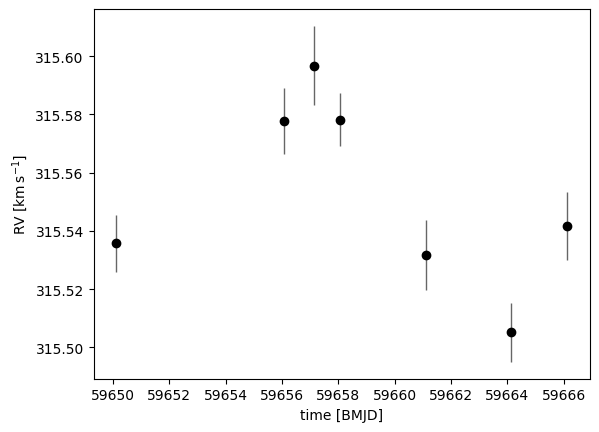

In [3]:
t = [59650.10541174411, 59656.05310538688, 59657.12322433722, 59658.06083902933, 59661.1028844865, 59664.12167293875, 59666.11853265618]
rv = [315.5357, 315.5778, 315.5968, 315.5781, 315.5318, 315.5052, 315.5417] * u.km/u.s
err = [0.0098, 0.0114, 0.0136, 0.0091, 0.012, 0.0102, 0.0118] * u.km/u.s
data = tj.RVData(t=t, rv=rv, rv_err=err)
ax = data.plot()  
#ax.set_xlim(-10, 200)  

In [4]:
2**(28)

268435456

In [5]:
data = RVData(t=t, rv=rv, rv_err=err)
prior = JokerPrior.default(P_min=2*u.day, P_max=100*u.day,sigma_K0=((max(rv)-min(rv))/2), sigma_v=np.mean(rv))
joker = TheJoker(prior)

print("Listo")

Listo


In [6]:
prior

<JokerPrior [P, e, omega, M0, s, K, v0]>

In [7]:
rng = np.random.default_rng(seed=42)
prior_samples = prior.sample(size=2_000_000, rng=rng)
#prior_samples.write("prior_samples1.hdf5", overwrite=True)

In [8]:
samples = joker.rejection_sample(data, prior_samples)

In [9]:
samples = samples.wrap_K()


In [10]:
samples

<JokerSamples [P, e, omega, M0, s, K, v0] (4232 samples)>

(59648.0, 59668.0)

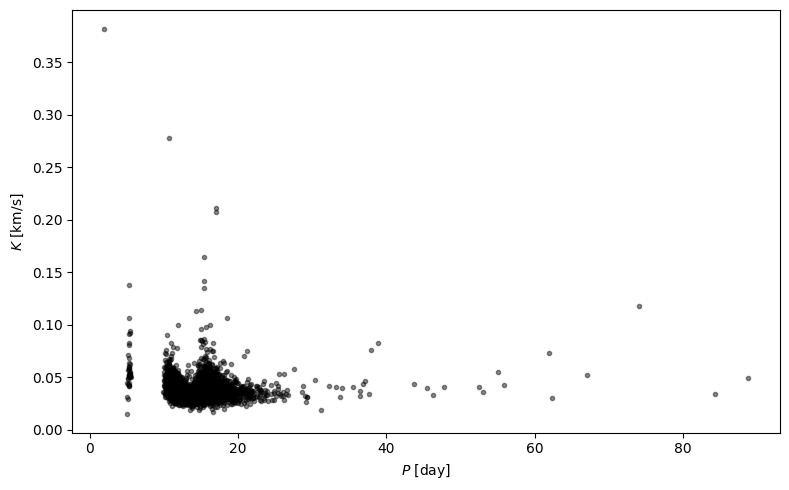

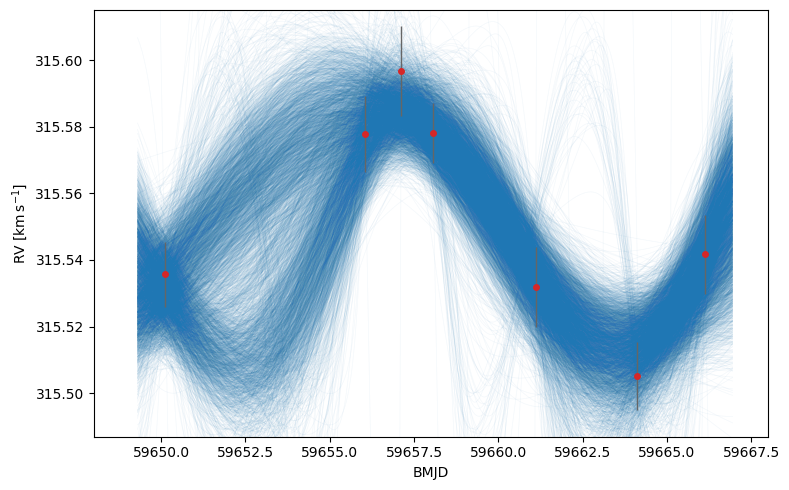

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="tight")
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,marker='.', color='k', alpha=0.45)

ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")
#ax.set_xlim(0, 256)
#ax.set_ylim(0.75, 3.)

#ax.scatter(61.942, 1.3959, marker='o', color='#31a354', zorder=-100)

fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="tight")
#t_grid = np.linspace(59614, 59668, 1024)
t_grid = np.linspace(59648, 59668, 1024)

_ = tj.plot_rv_curves(samples,data=data,plot_kwargs=dict(color="tab:blue"),data_plot_kwargs=dict(color="tab:red"),relative_to_t_ref=False,ax=ax)

# ax.set_xlim(59614, 59668)
ax.set_xlim(59648, 59668)
#ax.set_ylim(315.35,315.8)

In [12]:
samples

<JokerSamples [P, e, omega, M0, s, K, v0] (4232 samples)>

In [13]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="tight")
# for j in range(len(samples)):
#     _ = tj.plot_phase_fold(samples[j], data=data)

Text(0, 0.5, '$e$')

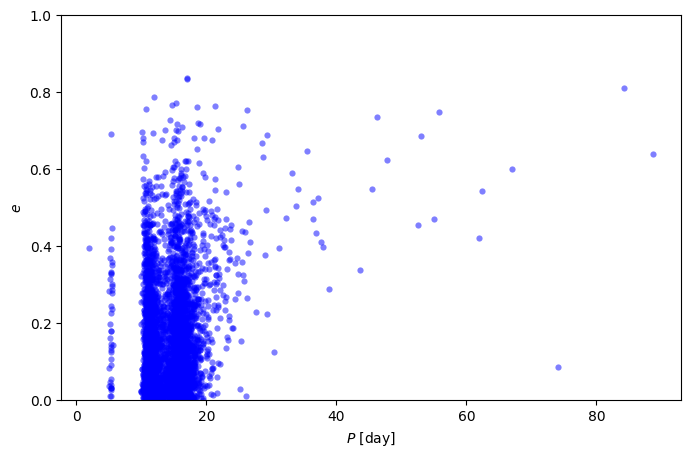

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.scatter(samples["P"], samples["e"], s=20, lw=0, alpha=0.5, color = 'blue')

#ax.set_xscale("log")
#ax.set_xlim(1, 1e2)
ax.set_ylim(0, 1)

ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$e$")

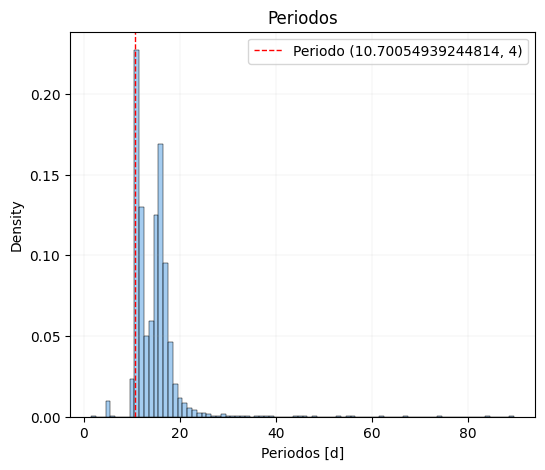

In [17]:
plt.figure(figsize=(6,5))
plt.xlabel('Periodos [d]')
plt.ylabel('')
plt.title('Periodos')
sns.histplot(samples["P"].value,stat='density', bins = "doane",alpha=0.5, cumulative=False, element='bars', discrete = True, color = '#4B9BE2')
plt.axvline(stat.mode(samples["P"].value), color = "red", linewidth = 1, linestyle = "dashed", label = f'Periodo {stat.mode(samples["P"].value),4}')
plt.legend()
plt.grid(linestyle='-', linewidth=0.1)
plt.show()

### Muestra MCMC

In [21]:
with prior.model:
    mcmc_init = joker.setup_mcmc(data, samples)
    trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)

/tmp/ipykernel_4110/1984993535.py:3: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, K, v0]


Output()

Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 57 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [22]:
az.summary(trace, var_names=prior.par_names)

/home/alexandert/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,11.150,0.808,10.010,12.458,0.092,0.068,171.0,70.0,1.01
e,0.157,0.126,0.000,0.384,0.007,0.005,321.0,366.0,1.00
omega,0.761,1.657,-2.569,3.081,0.105,0.078,297.0,551.0,1.00
M0,-0.024,2.168,-3.118,2.880,0.125,0.116,431.0,585.0,1.02
s,0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
K,-0.042,0.008,-0.056,-0.026,0.001,0.001,168.0,154.0,1.01
v0,315.545,0.005,315.536,315.555,0.000,0.000,345.0,497.0,1.00


In [23]:
mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
mcmc_samples = mcmc_samples.wrap_K()

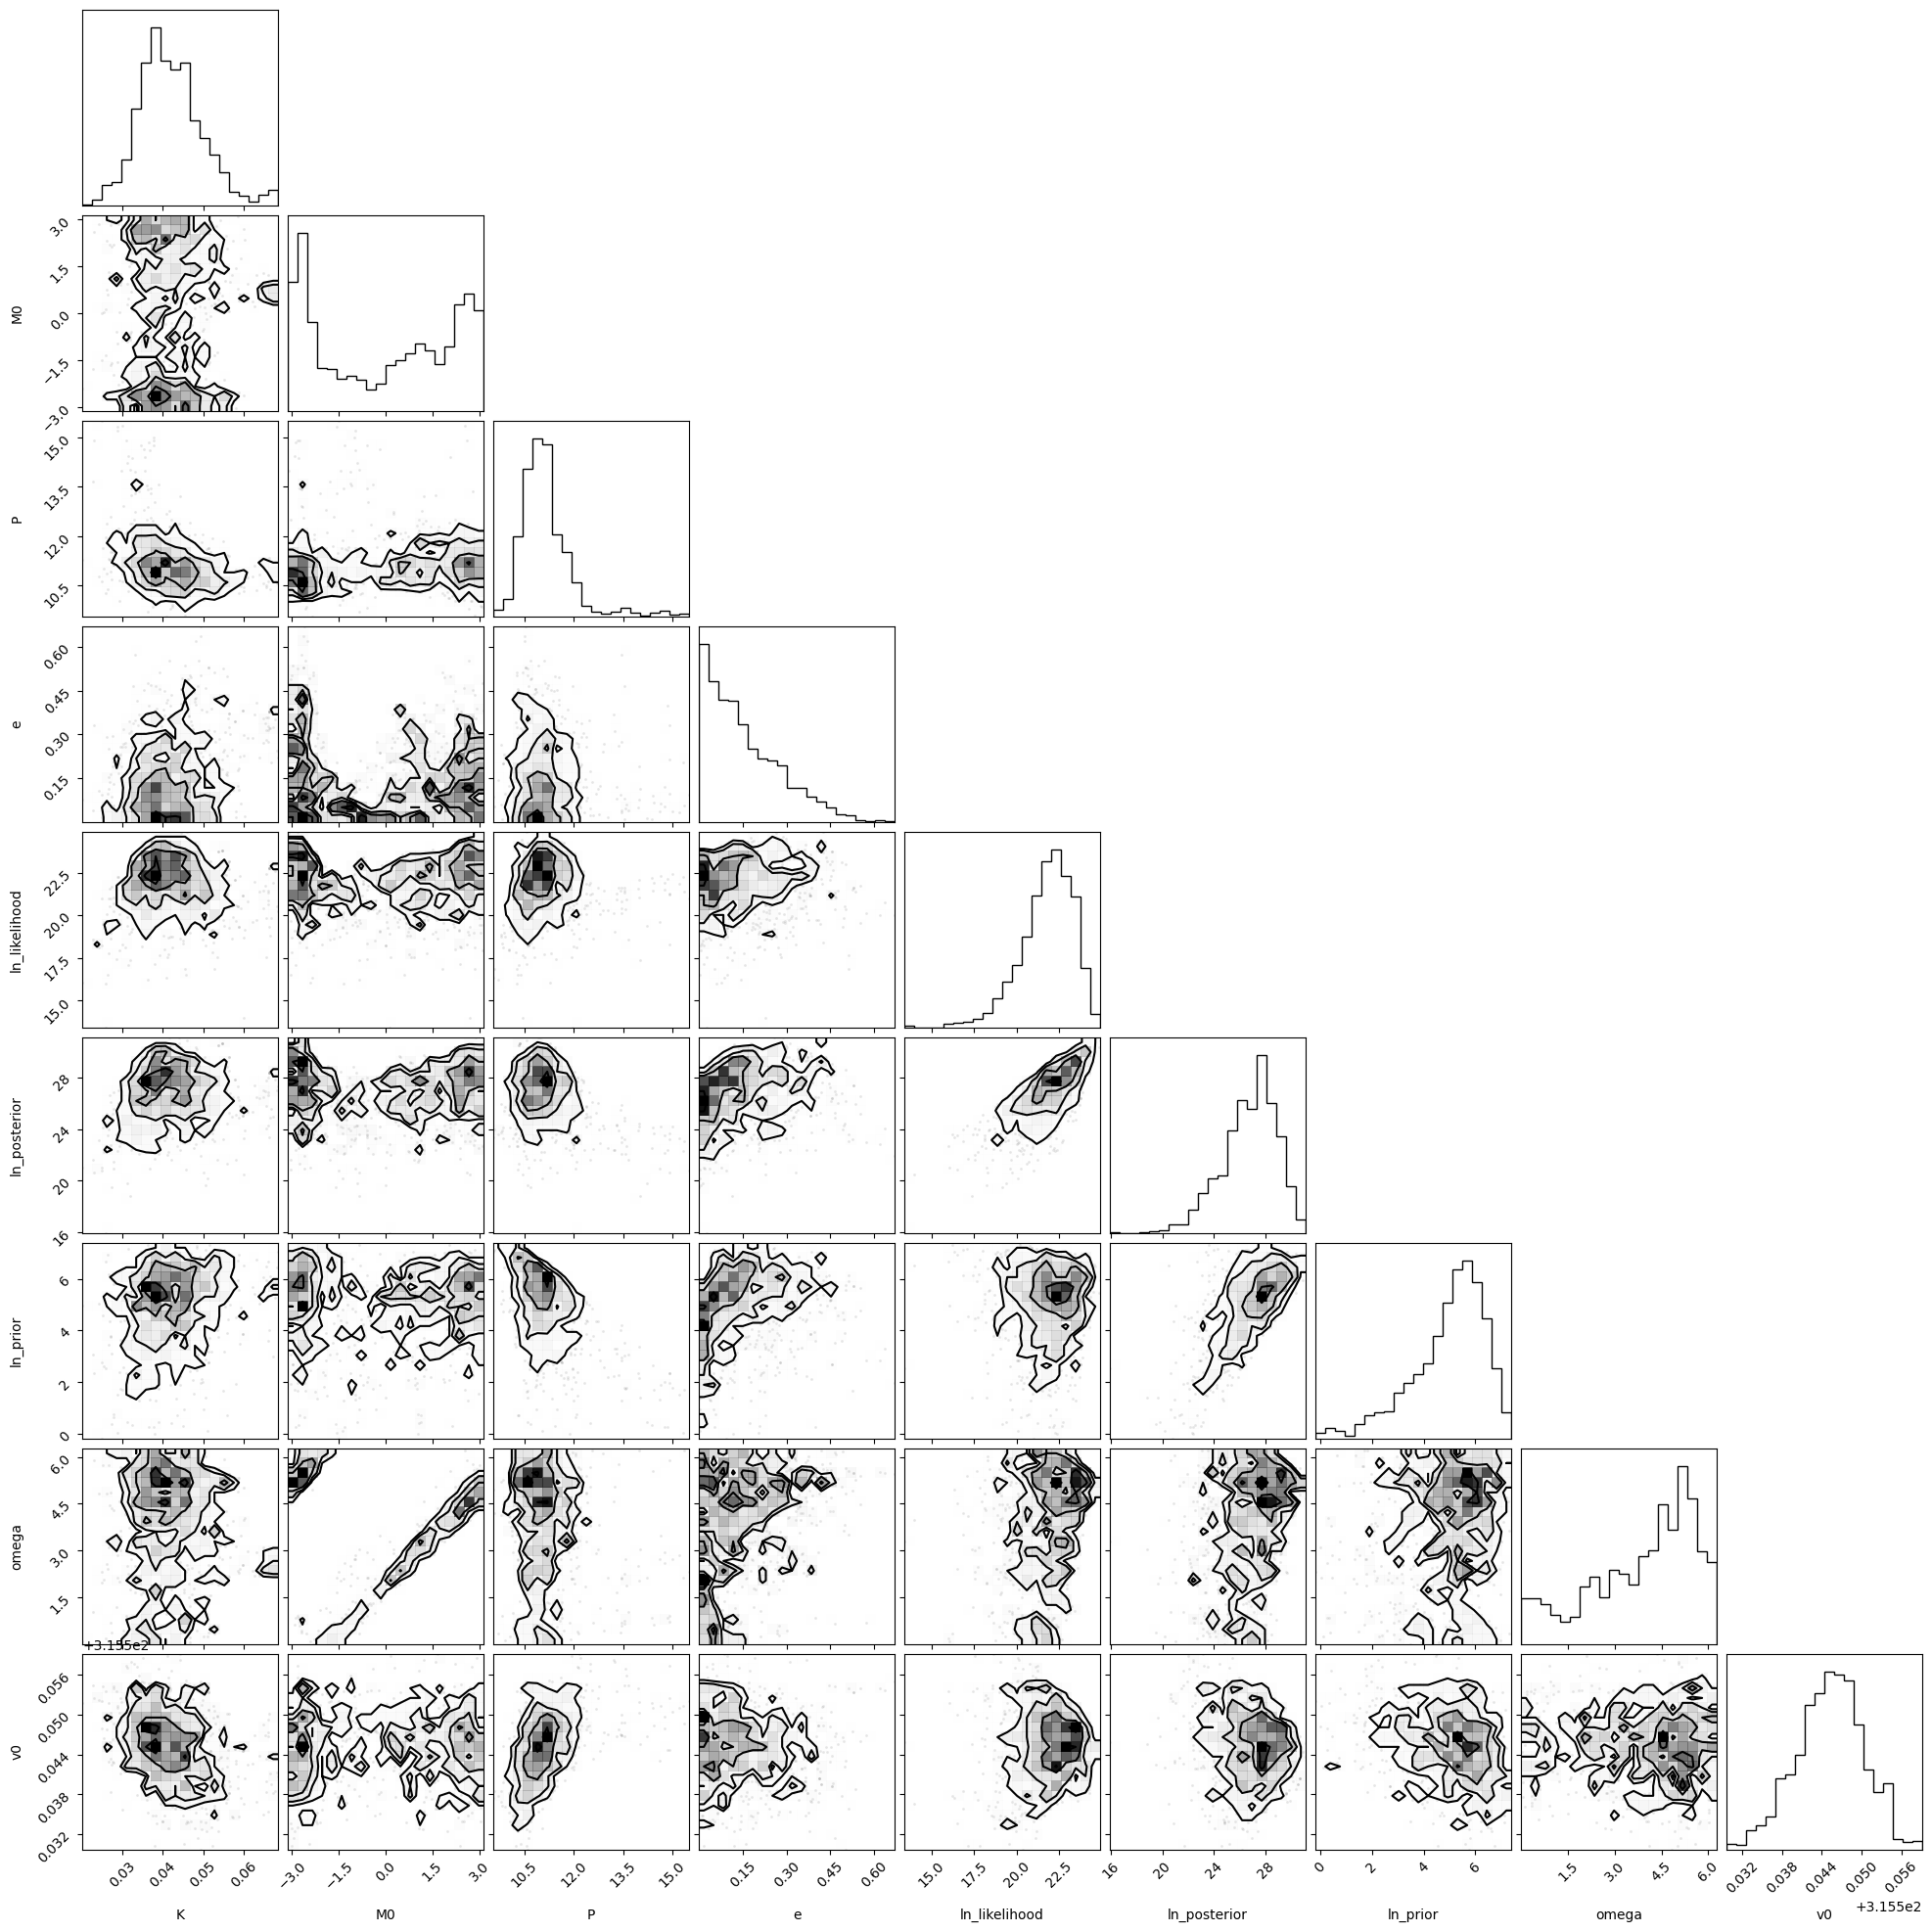

In [24]:
df = mcmc_samples.tbl.to_pandas()
colnames = mcmc_samples.par_names
colnames.pop(colnames.index("s"))
_ = corner.corner(df[colnames])

### Grafico de distribuciones

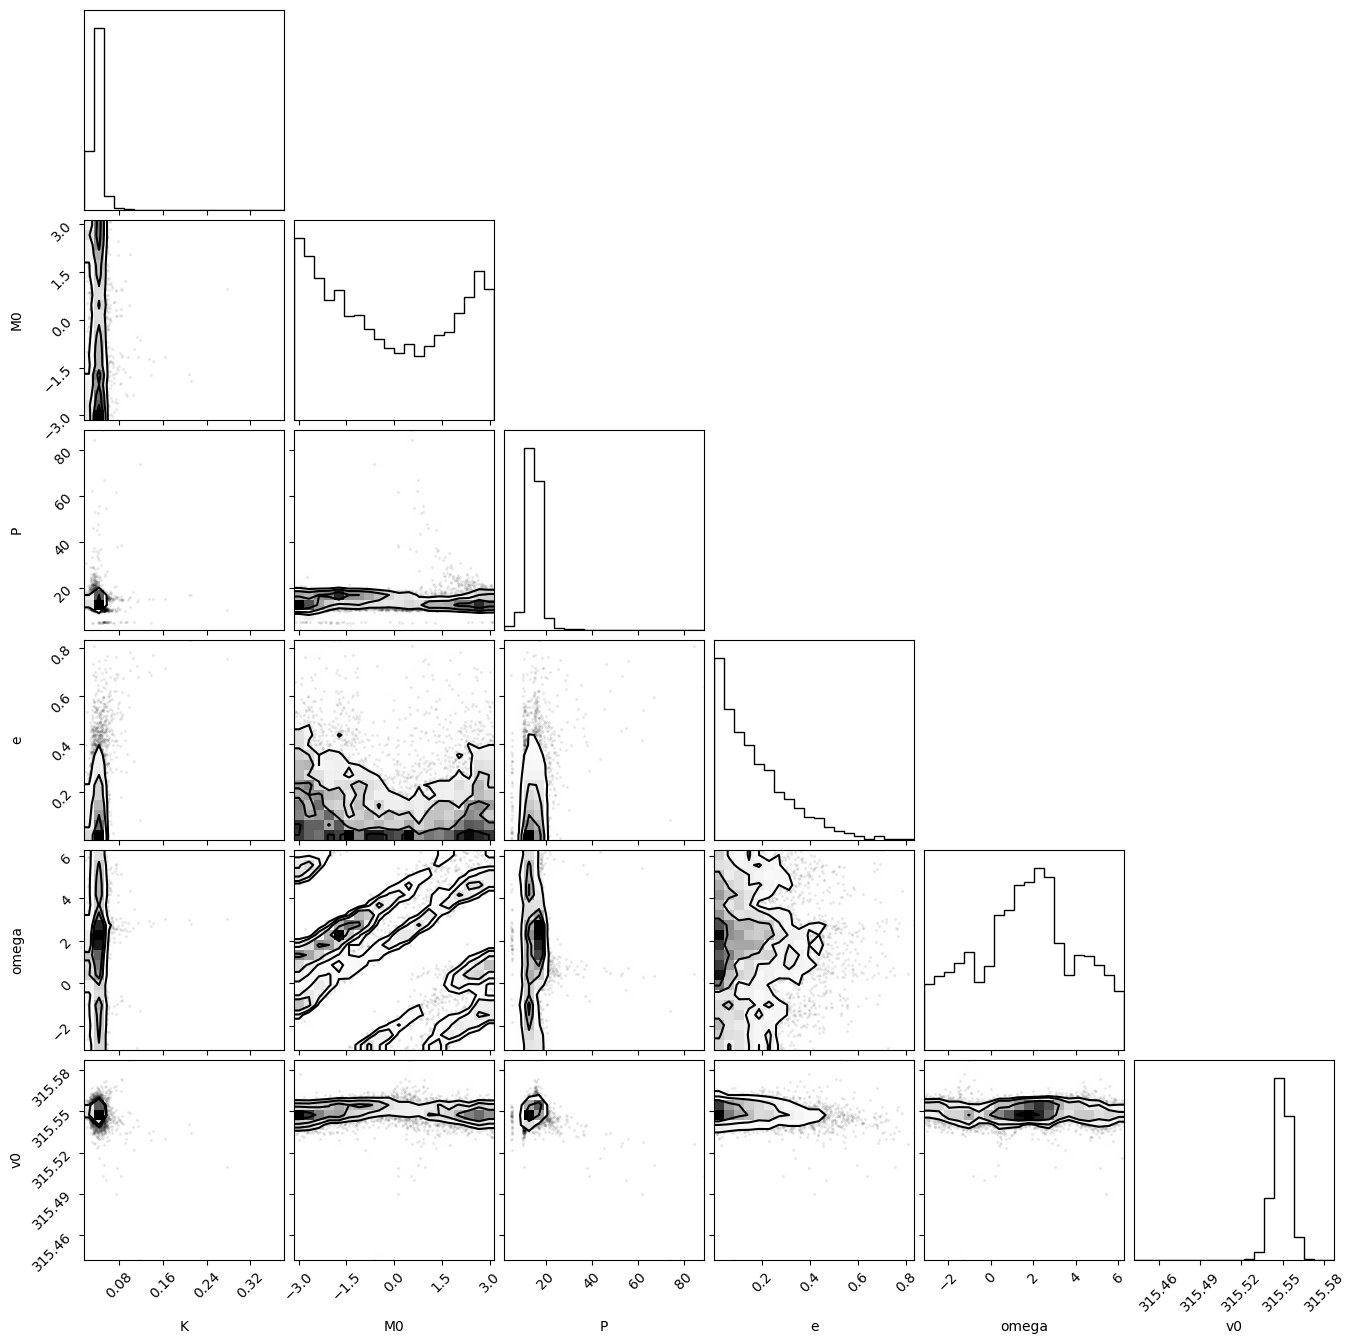

In [18]:
df = samples.tbl.to_pandas()
colnames = samples.par_names
colnames.pop(colnames.index("s"))
_ = corner.corner(df[colnames])

In [21]:
df

,P,e,omega,M0,s,K,v0
0,10.700549,0.352231,-0.599078,-2.435293,0.0,0.034744,315.550241
1,16.012707,0.211604,0.865647,2.898035,0.0,0.050601,315.561799
2,14.936624,0.217463,-2.764944,-0.482468,0.0,0.055522,315.554059
3,16.526881,0.395749,1.140045,-3.072956,0.0,0.029456,315.542781
4,14.372896,0.069571,-2.985292,-0.256972,0.0,0.043218,315.554043
...,...,...,...,...,...,...,...
4227,18.300567,0.117010,5.513614,0.971101,0.0,0.043185,315.552055
4228,16.555156,0.246887,5.763652,1.503893,0.0,0.039927,315.557792
4229,11.075796,0.005418,0.027052,-2.050576,0.0,0.048641,315.544340
4230,5.428700,0.236690,1.604586,-3.064709,0.0,0.050155,315.550459


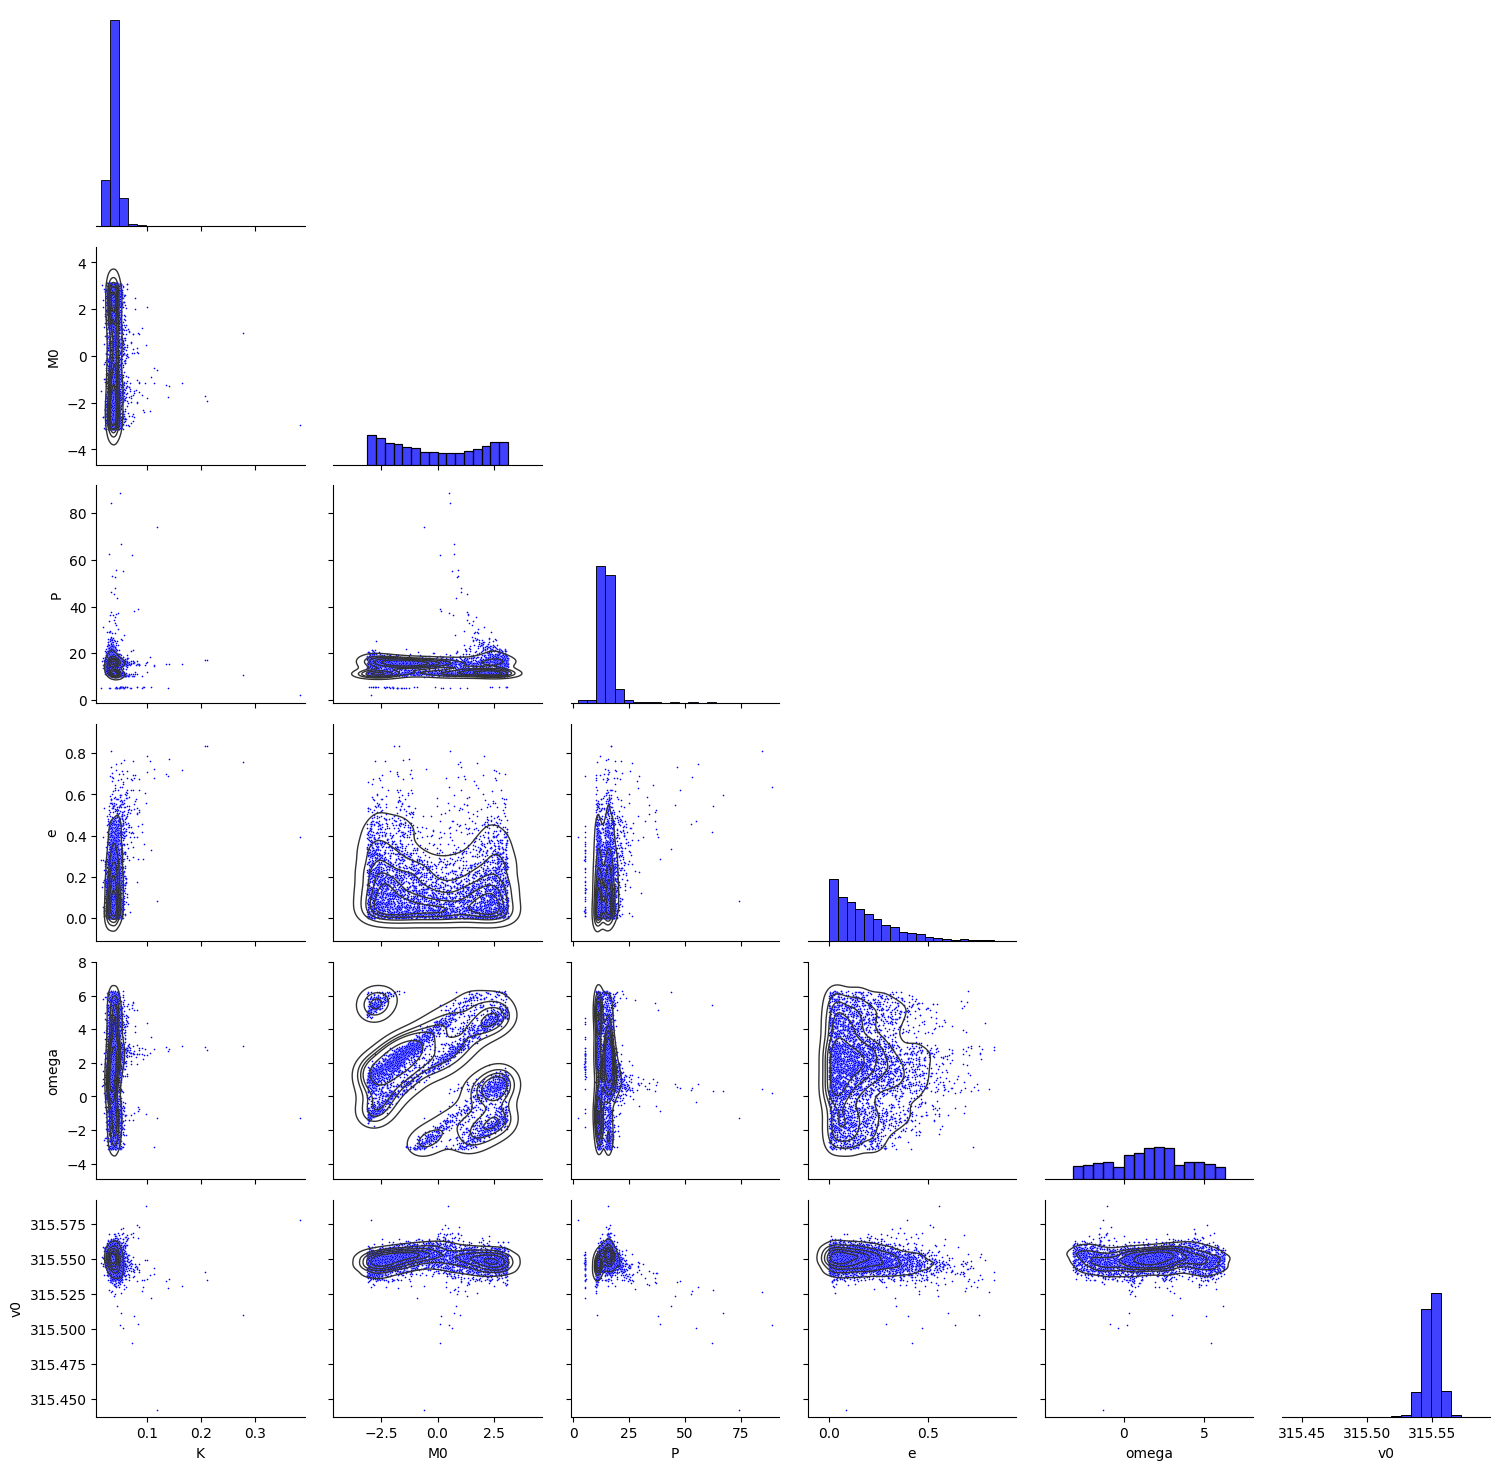

In [65]:
# Crear un gráfico de correlación utilizando pairplot
g = sns.PairGrid(df, 
            x_vars=["K", "M0", "P", "e", "omega", "v0"],
            y_vars=["K", "M0", "P", "e", "omega", "v0"],
            #plot_kws=dict(marker=".", linewidth=1),        # Edito los scatter
            #diag_kws=dict(fill=False),                     # Edito los histogramas
            corner=True)                                   # No muestra las de encima de la diagonal
# Mostrar el gráfico
g.map_diag(sns.histplot, bins = "doane", color = "blue")              #Histogramas en la diagonal
g.map_lower(sns.kdeplot,linewidths = 1, levels=6,  color=".2",thresh=.1)             # Muestra los contornos
g.map_lower(sns.scatterplot,s = 1.5, color="blue")                     # Muestra los puntos
#plt.show()

In [25]:
# print("Periodo: ",samples["P"])
# print("Excentricidad",samples["e"])
# print("Excentricidad",samples["omega"])
# print("Excentricidad",samples["M0"])
# print("Excentricidad",samples["s"])
# print("Excentricidad",samples["K"])
# print("Excentricidad",samples["v0"])

In [26]:
samples.median_period()

<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>

Número de muestras mínimas establecidas (estas serían los datos resultantes, los aprovados, los posteriores admitidos)

$$M_{min} = 128$$

Resolución del periodo:

$$Δ =  \frac{4P^2}{2\pi T}$$

Los tres resultados posibles son los siguientes:
1. $M >> M_{min}$ muestras sobreviven al rechazo. En este caso, hemos terminado.
   
3. $M < M_{min}$ muestras sobreviven al rechazo, y estas muestras tienen una varianza de raíz (rms) en el parámetro de periodo P que es menor que Δ (es decir, no dan ninguna indicación de ambigüedad de periodo). En este caso suponemos que la pdf posterior es efectivamente unimodal, y utilizamos las muestras supervivientes (o muestra) para inicializar un muestreo MCMC utilizando el paquete emcee (Foreman-Mackey et al. 2013).
   
5. $M < M_{min}$ muestras sobreviven al rechazo, y estas muestras abarcan un intervalo de periodos mayor que Δ. En este caso, iteramos el procedimiento de muestreo de rechazo: generamos nuevos muestreos pdf previos y muestreos de rechazo hasta que el número de muestras supervivientes sea mayor que Mmin. Esto es costoso.

In [27]:
P = np.median(samples["P"])
T = 49*u.d
Δ =  (4*P**2)/(2*np.pi*T)
Δ

<Quantity 2.77938293 d>

In [28]:
rmsValue(samples["P"].value, len(samples["P"].value))*u.d

<Quantity 15.28078795 d>

### Función de masa binaria
$$f(M) = \frac{M_2 \sin^3(i)}{(1+q)^2} = \frac{PK_1^3 (1-e^2)^{3/2}}{2\pi G}$$

Con $q = \frac{M_1}{M_2}$

In [16]:
P = 0.866605*u.d
e = 0.007
K = 122.7*1000*u.m*1/u.s
G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2

In [17]:
f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
f = f.cgs
f = (f/(1.989e+33*u.g)*u.M_sun)
f

<Quantity 0.16581214 solMass>

In [18]:
M1 = 1.65*u.M_sun

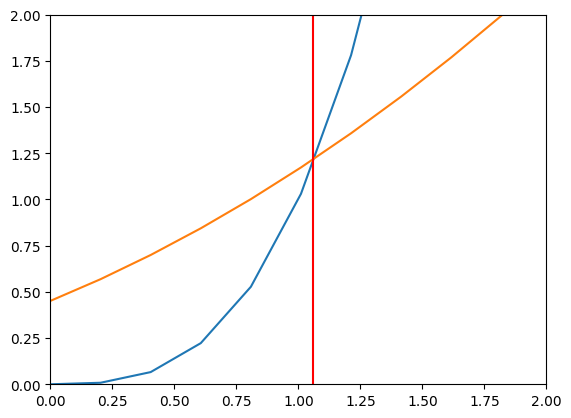

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x = np.linspace(0, 20, 100)
plt.plot(
    x, x**3, 
    x, (M1.value + x)**2*f.value
)
plt.ylim(0,2)
plt.xlim(0,2)
plt.axvline(1.06, color = 'red');


plt.show()

In [20]:
def resolver_ecuacion_cubica(a, b, c, d):
    coeficientes = [a, b, c, d]
    raices = np.roots(coeficientes)
    return raices

# Ejemplo de uso
a = 1
b = -f.value
c = -2*M1.value*f.value
d = -M1.value**2*f.value

raices = resolver_ecuacion_cubica(a, b, c, d)
print("Las raíces de la ecuación son:", raices)

Las raíces de la ecuación son: [ 1.07067129+0.j         -0.45242958+0.46576188j -0.45242958-0.46576188j]


In [29]:
# En nuestro caso
P = np.mean(samples["P"])
e = np.mean(samples["e"]) 
K = np.mean(samples["K"]).value*1000*u.m*1/u.s

In [30]:
def f(P,e,K):
    G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
    f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
    f = f.cgs
    f = (f/(1.989e+33*u.g)*u.M_sun)
    return f

In [31]:
f_value = f(P,e,K)
print(P)
print(f_value)

14.61348684448291 d
9.755779646417331e-11 solMass


In [43]:
K

NameError: name 'K' is not defined

In [32]:
M1 = 0.8*u.M_sun

In [33]:
sini =  1

In [34]:
np.arcsin(sini)*180/np.pi

90.0

In [35]:
# Ejemplo de uso
def resolver_ecuacion_cubica(a, b, c, d):
    coeficientes = [a, b, c, d]
    raices = np.roots(coeficientes)
    return raices
    
a = (sini)**3
b = -f_value.value
c = -2*M1.value*f_value.value
d = -M1.value**2*f_value.value

raices = resolver_ecuacion_cubica(a, b, c, d)
print("Las raíces de la ecuación son:", raices)

Las raíces de la ecuación son: [ 0.00039685+0.j         -0.00019842+0.00034345j -0.00019842-0.00034345j]


In [63]:
M2 = raices[0].real*u.M_sun
M_jupiter = 1.898e27*u.kg
print("La masa del objeto en M_Sun, M2 = ",M2)
print("La masa del objeto en kg, M2 = ",M2.to("kg"))
print("La masa del objeto en M_J, M2 = ",M2.to("M_jup"))

La masa del objeto en M_Sun, M2 =  0.00039684804081691457 solMass
La masa del objeto en kg, M2 =  7.890965615275359e+26 kg
La masa del objeto en M_J, M2 =  0.4157243221203732 jupiterMass


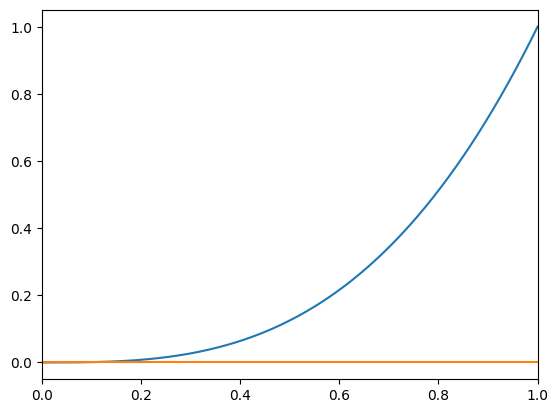

In [54]:
x = np.linspace(0, raices[0].real+1, 1000)

plt.plot(x, x**3*((sini)**3), x, (M1.value + x)**2*f_value.value)
# 
#plt.ylim(-0.5e-9,10e-9)
plt.xlim(0,raices[0].real+1)
# plt.axvline(1.7484169, color = 'red');


plt.show()